In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob  # Para manejar múltiples archivos

# Configuración de seaborn para gráficos mas agradables
sns.set_theme(style="whitegrid")

In [4]:

files = glob.glob("stats-ej1-d/*.txt") # Recolectar archivos con métricas

print(files)

data_list = []

for file in files: # Leer cada archivo y extraer las métricas en el DataFrame
    with open(file, 'r') as f:
        metrics = {}
        for line in f:
            metric, value = line.split() # Dividir cada línea en métrica y valor
            metrics[metric] = float(value)
        data_list.append(pd.DataFrame([metrics]))

data = pd.concat(data_list, ignore_index=True)

print(data.head())

['stats-ej1-d/stats-16k-2.txt', 'stats-ej1-d/stats-8k-8.txt', 'stats-ej1-d/stats-8k-1.txt', 'stats-ej1-d/stats-8k-2.txt', 'stats-ej1-d/stats-32k-1.txt', 'stats-ej1-d/stats-16k-8.txt', 'stats-ej1-d/stats-32k-2.txt', 'stats-ej1-d/stats-8k-4.txt', 'stats-ej1-d/stats-32k-4.txt', 'stats-ej1-d/stats-16k-4.txt', 'stats-ej1-d/stats-16k-1.txt', 'stats-ej1-d/stats-32k-8.txt']
   system.cpu_cluster.cpus.numCycles  \
0                           188827.0   
1                           243009.0   
2                           218302.0   
3                           189255.0   
4                           218366.0   

   system.cpu_cluster.cpus.dcache.overallHits::total  \
0                                             4782.0   
1                                            10755.0   
2                                              698.0   
3                                             4781.0   
4                                              704.0   

   system.cpu_cluster.cpus.dcache.ReadReq.hits::total

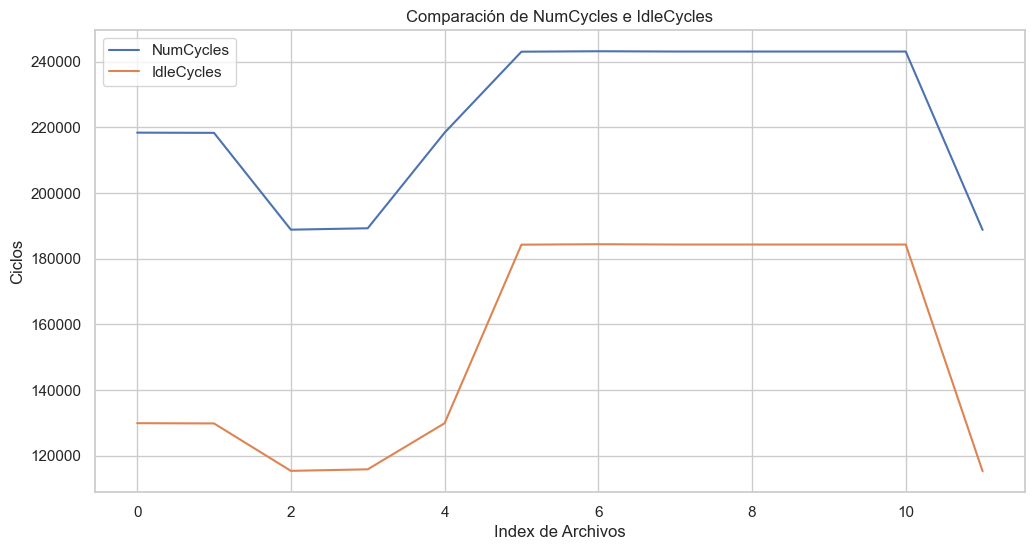

In [9]:

# Graficar 'numCycles' y 'idleCycles' para comparar
plt.figure(figsize=(12, 6))
plt.plot(data['system.cpu_cluster.cpus.numCycles'], label='NumCycles')
plt.plot(data['system.cpu_cluster.cpus.idleCycles'], label='IdleCycles')
plt.xlabel('Index de Archivos')
plt.ylabel('Ciclos')
plt.title('Comparación de NumCycles e IdleCycles')
plt.legend()
plt.show()

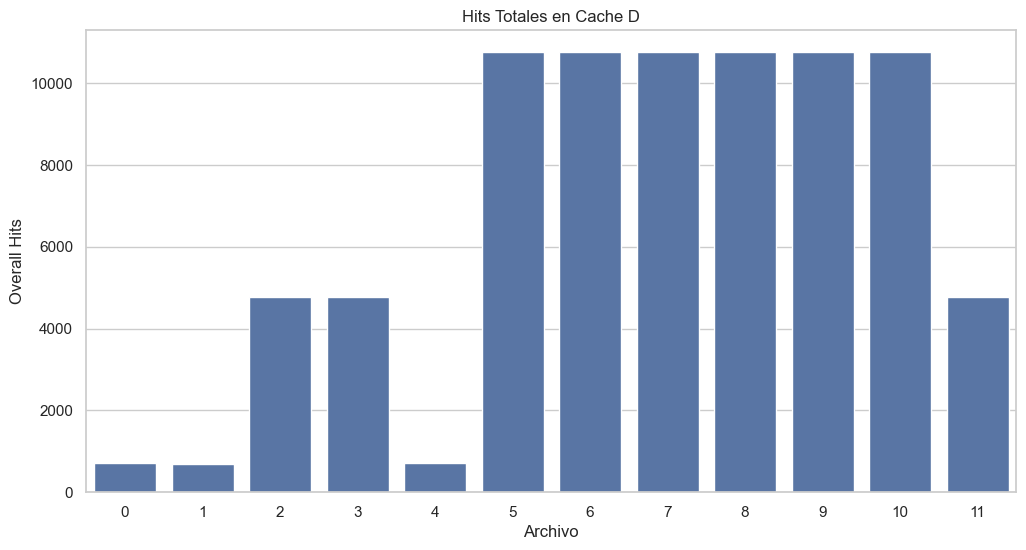

In [10]:
# Paso 6: Gráfico de barras para una métrica específica
plt.figure(figsize=(12, 6))
sns.barplot(data=data, x=data.index, y='system.cpu_cluster.cpus.dcache.overallHits::total')
plt.xlabel('Archivo')
plt.ylabel('Overall Hits')
plt.title('Hits Totales en Cache D')
plt.show()